In [1]:
import glob
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
import sys
import copy
import os

import yaml
import numpy as np
import matplotlib.pyplot as plt
import dask
import distributed
import dask_jobqueue
from dask_jobqueue import PBSCluster
import astropy.units as u
from astropy.visualization import ImageNormalize, AsinhStretch
import sunpy.map
from sunpy.instr.aia import aiaprep
import ndcube

import aiacube
from aiacube.prep import register_and_derotate
sys.path.append('../../scripts/')
from drms_on_ames import Client

%matplotlib inline

# Saving Level 2 Data Cubes with `zarr`

Often, we want to do our analysis on so-called "level 2" data products. In the context of AIA observations, a level 2 image has been modified in the following way:

1. Rotated, centered, and scaled such that the image of the Sun is at the center of the image, the y-axis is aligned with solar north, and the resolution is 0.6 arcseconds per pixel
2. Normalized to the exposure time
3. Reprojected to remove the effect of solar rotation

Ideally, we would do carry out this series of "prep" operations on our data exactly once and then export the higher level data product to a format that we can easily read in and manipulate later on.

In this notebook, we'll show how to query 2 hours of AIA observations of AR 11082, run them through the level 2 data prep pipeline, and export these level 2 data cubes to the `zarr` file format. 

## Querying Data

In [2]:
c = Client(ssh=True)

In [3]:
keys, q = c.query(
    'aia.lev1[2010-06-19T00:00:00/10m]',
    seg=['image_lev1'],
    key=['WAVELNTH']
)

In [4]:
q

image_lev1
0    /nobackup/drms/SUM6/D151012840/S00000/image_le...
1    /nobackup/drms/SUM1/D151012841/S00000/image_le...
2    /nobackup/drms/SUM4/D151012842/S00000/image_le...
3    /nobackup/drms/SUM1/D151012843/S00000/image_le...
4    /nobackup/drms/SUM4/D151012844/S00000/image_le...
..                                                 ...
395  /nobackup/drms/SUM6/D151013771/S00000/image_le...
396  /nobackup/drms/SUM2/D151013780/S00000/image_le...
397  /nobackup/drms/SUM6/D151013781/S00000/image_le...
398  /nobackup/drms/SUM3/D151013782/S00000/image_le...
399  /nobackup/drms/SUM4/D151013783/S00000/image_le...

[400 rows x 1 columns]

In [5]:
files = (q[(keys['WAVELNTH'] == 94) |
           (keys['WAVELNTH'] == 131) |
           (keys['WAVELNTH'] == 171) |
           (keys['WAVELNTH'] == 193) |
           (keys['WAVELNTH'] == 211) |
           (keys['WAVELNTH'] == 335)]
         .values
         .squeeze()
         .tolist())

## Data Prep Pipeline

First, create a Dask cluster for processing our data

In [2]:
cluster = distributed.LocalCluster()

In [3]:
client = distributed.Client(cluster)

Next, load each file into a `sunpy.map.Map` object

In [8]:
maps = client.map(sunpy.map.Map, files, pure=True)

Then separate out the maps into their respective wavelengths.

In [9]:
headers = client.map(lambda x: x.meta, maps, pure=True)

In [10]:
headers = client.gather(headers)

In [11]:
maps_94 = [m for (m,h) in zip(maps,headers) if h['wavelnth']==94]
maps_131 = [m for (m,h) in zip(maps,headers) if h['wavelnth']==131]
maps_171 = [m for (m,h) in zip(maps,headers) if h['wavelnth']==171]
maps_193 = [m for (m,h) in zip(maps,headers) if h['wavelnth']==193]
maps_211 = [m for (m,h) in zip(maps,headers) if h['wavelnth']==211]
maps_335 = [m for (m,h) in zip(maps,headers) if h['wavelnth']==335]

Lastly, apply the `aiacube.register_and_derotate` function to each set of maps in order to convert the level 1 data to level 2

In [12]:
maps_94_lvl_2 = register_and_derotate(maps_94)

In [13]:
maps_131_lvl_2 = register_and_derotate(maps_131)

In [14]:
maps_171_lvl_2 = register_and_derotate(maps_171)

In [15]:
maps_193_lvl_2 = register_and_derotate(maps_193)

In [16]:
maps_211_lvl_2 = register_and_derotate(maps_211)

In [17]:
maps_335_lvl_2 = register_and_derotate(maps_335)

## Making Data Cubes and Exporting to Zarr

First, create data cubes from the future objects returned from the prep pipeline

In [18]:
cube_94 = aiacube.AIACube.from_futures(maps_94_lvl_2)
cube_131 = aiacube.AIACube.from_futures(maps_131_lvl_2)
cube_171 = aiacube.AIACube.from_futures(maps_171_lvl_2)
cube_193 = aiacube.AIACube.from_futures(maps_193_lvl_2)
cube_211 = aiacube.AIACube.from_futures(maps_211_lvl_2)
cube_335 = aiacube.AIACube.from_futures(maps_335_lvl_2)

Changed DATE-OBS from '2010-06-19 00:00:08.110' to '2010-06-19T00:00:08.110''. [astropy.wcs.wcs]
Changed DATE-OBS from '2010-06-19 00:00:09.600' to '2010-06-19T00:00:09.600''. [astropy.wcs.wcs]
Changed DATE-OBS from '2010-06-18 23:59:59.130' to '2010-06-18T23:59:59.130''. [astropy.wcs.wcs]
Changed DATE-OBS from '2010-06-19 00:00:06.630' to '2010-06-19T00:00:06.630''. [astropy.wcs.wcs]
Changed DATE-OBS from '2010-06-19 00:00:00.630' to '2010-06-19T00:00:00.630''. [astropy.wcs.wcs]
Changed DATE-OBS from '2010-06-19 00:00:03.600' to '2010-06-19T00:00:03.600''. [astropy.wcs.wcs]


Let's play around with the data cube to make sure it looks as we would expect.

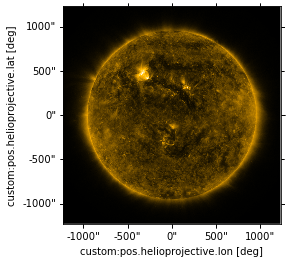

In [31]:
cube_171[-1,:,:].plot(
    cmap='sdoaia171',
    norm=ImageNormalize(vmin=0,vmax=2e3,stretch=AsinhStretch())
)

In [40]:
subcube_171 = cube_171.crop_by_coords(
    (0*u.s, 300*u.arcsec, -450*u.arcsec),
    upper_corner=(1*u.h, 600*u.arcsec, -150*u.arcsec),
)

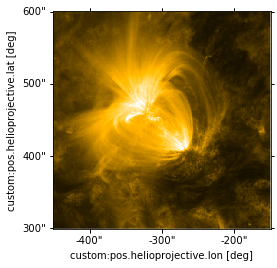

In [41]:
subcube_171[-1,:,:].plot(
    cmap='sdoaia171',
    norm=ImageNormalize(vmin=0,vmax=2e3,stretch=AsinhStretch())
)

And then use the `.to_zarr` method to write them to a Zarr dataset. Note that each data cube will be written to the same dataset, but a different group denoted by the wavelength.

In [19]:
cube_94.to_zarr('/nobackup/wtbarnes/test_zarr_cubes/noaa_11082',)

In [20]:
cube_131.to_zarr('/nobackup/wtbarnes/test_zarr_cubes/noaa_11082',)

In [21]:
cube_171.to_zarr('/nobackup/wtbarnes/test_zarr_cubes/noaa_11082',)

In [22]:
cube_193.to_zarr('/nobackup/wtbarnes/test_zarr_cubes/noaa_11082',)

In [23]:
cube_211.to_zarr('/nobackup/wtbarnes/test_zarr_cubes/noaa_11082',)

In [24]:
cube_335.to_zarr('/nobackup/wtbarnes/test_zarr_cubes/noaa_11082',)

## Importing from Zarr

Now, let's try to import a data cube from a zarr file.

In [4]:
cube_171_from_zarr = aiacube.AIACube.from_zarr(
    '/nobackup/wtbarnes/test_zarr_cubes/noaa_11082/',
    171*u.angstrom,
)

In [46]:
subcube_171_from_zarr = cube_171_from_zarr.crop_by_coords(
    (0*u.s, 300*u.arcsec, -450*u.arcsec),
    upper_corner=(12*u.h, 600*u.arcsec, -150*u.arcsec),
)

In [47]:
subcube_171_from_zarr.data

dask.array<getitem, shape=(50, 502, 502), dtype=float64, chunksize=(1, 502, 502), chunktype=numpy.ndarray>

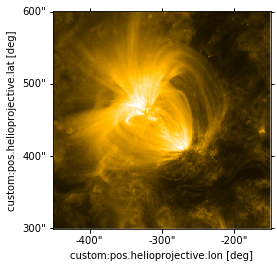

In [48]:
subcube_171_from_zarr[0,:,:].plot(
    cmap='sdoaia171',
    norm=ImageNormalize(vmin=0,vmax=2e3,stretch=AsinhStretch())
)

Additionally, we can plot the first frame for all of the channels.

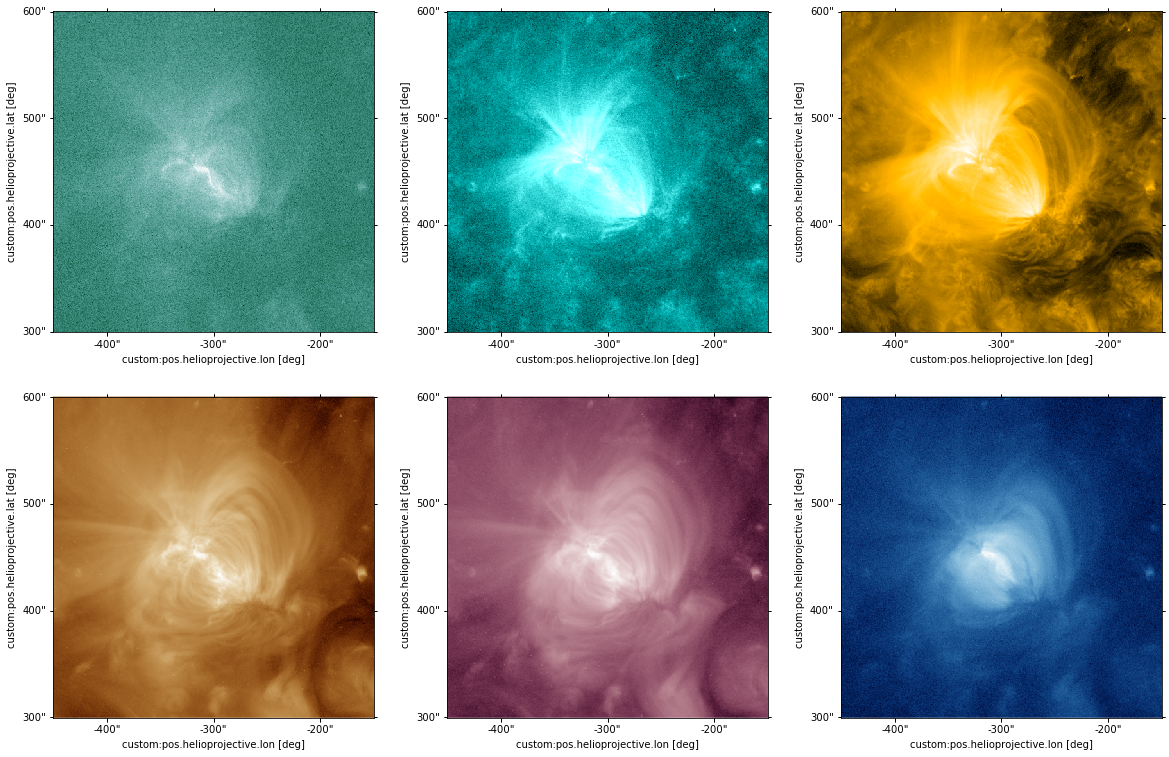

In [45]:
fig = plt.figure(figsize=(20,13))
for i,c in enumerate([94,131,171,193,211,335]*u.angstrom):
    cube = aiacube.AIACube.from_zarr('/nobackup/wtbarnes/test_zarr_cubes/noaa_11082/', c)
    s = cube.crop_by_coords(
        (0*u.s, 300*u.arcsec, -450*u.arcsec),
        upper_corner=(1*u.s, 600*u.arcsec, -150*u.arcsec),
    )[0,:,:]
    m = s.maps[0] 
    ax = fig.add_subplot(2,3,i+1, projection=m)
    s.plot(axes=ax, **m.plot_settings)